In [1]:
# imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import matplotlib.gridspec as gridspec
#from sklearn.metrics import silhouette_score

result_dir = "../results/revision/analysis/"
plot_dir = "../results/revision/plots/"

cm = 1 / 2.54

/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python

## make predictions (multiDGD)

In [2]:
import scvi
import torch
import pandas as pd
import anndata as ad
import numpy as np
from omicsdgd import DGD

save_dir = "../results/trained_models/"
data_name = "human_bonemarrow"
# in this dictionary we will have the fractions and the corresponding number of samples in the train set
fraction_dict = {0.01: 567, 0.1: 5671, 0.25: 14178, 0.5: 28357, 0.75: 42535, 1.0: 56714}

"""
Go through datasets and chosen models and compute reconstruction performances
"""
data_name = "human_bonemarrow"
adata = ad.read_h5ad("../../data/" + data_name + ".h5ad")
adata.X = adata.layers["counts"]

/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [3]:
train_indides = np.where(adata.obs["train_val_test"] == "train")[0]
trainset = adata[train_indides, :].copy()
test_indides = np.where(adata.obs["train_val_test"] == "test")[0]
testset = adata[test_indides, :].copy()
modality_switch = 13431
library = torch.cat(
    (
        torch.sum(
            torch.Tensor(testset.X.todense())[:, :modality_switch], dim=-1
        ).unsqueeze(1),
        torch.sum(
            torch.Tensor(testset.X.todense())[:, modality_switch:], dim=-1
        ).unsqueeze(1),
    ),
    dim=1,
)
#trainset_all = trainset.copy()
df_subset_ids = pd.read_csv("../../data/" + data_name + "_data_subsets.csv")

fraction = 0.01
subset = fraction_dict[fraction]

train_indices = list(
    df_subset_ids[
        (df_subset_ids["fraction"] == fraction)
        & (df_subset_ids["include"] == 1)
    ]["sample_idx"].values
)
trainset_small = adata[train_indices].copy()
adata = None

In [5]:
model_name = "human_bonemarrow_l20_h2-3"

from omicsdgd import DGD
model = DGD.load(
    data=trainset, save_dir=save_dir + data_name + "/", model_name=model_name
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


In [7]:
model.test_rep.z

Parameter containing:
tensor([[-0.0307, -0.0154, -0.0355,  ...,  0.0658,  0.0442,  0.0972],
        [ 0.0926,  0.0370, -0.0463,  ..., -0.1100, -0.0548, -0.0826],
        [ 0.0193, -0.0454,  0.0332,  ..., -0.0366, -0.0882,  0.0588],
        ...,
        [ 0.1045,  0.0554, -0.0672,  ..., -0.1037, -0.0881, -0.0780],
        [-0.0563,  0.1882, -0.1956,  ...,  0.0342, -0.0424, -0.0170],
        [ 0.0659, -0.0069,  0.0114,  ..., -0.0932, -0.1377, -0.0272]],
       requires_grad=True)

In [8]:
predictions = model.predict_from_representation(
    model.test_rep, model.correction_test_rep
)

In [12]:
predictions[0] *= library[:, 0].unsqueeze(1)
predictions[1] *= library[:, 1].unsqueeze(1)

In [17]:
trainset = None
model = None

In [24]:
# save these predictions as numpy
np.save(
    result_dir + "performance/" + model_name + "_test_predictions_RNA.npy",
    predictions[0][::10].detach().numpy(),
)
np.save(
    result_dir + "performance/" + model_name + "_test_predictions_ATAC.npy",
    predictions[1][::100].detach().numpy(),
)

In [3]:
test_indides = np.where(adata.obs["train_val_test"] == "test")[0]
testset = adata[test_indides, :].copy()
modality_switch = 13431
library = torch.cat(
    (
        torch.sum(
            torch.Tensor(testset.X.todense())[:, :modality_switch], dim=-1
        ).unsqueeze(1),
        torch.sum(
            torch.Tensor(testset.X.todense())[:, modality_switch:], dim=-1
        ).unsqueeze(1),
    ),
    dim=1,
)
#trainset_all = trainset.copy()
df_subset_ids = pd.read_csv("../../data/" + data_name + "_data_subsets.csv")

fraction = 0.01
subset = fraction_dict[fraction]

train_indices = list(
    df_subset_ids[
        (df_subset_ids["fraction"] == fraction)
        & (df_subset_ids["include"] == 1)
    ]["sample_idx"].values
)
trainset = adata[train_indices].copy()
adata = None

In [4]:
model_name = (
            "human_bonemarrow_l20_h2-3_rs0_subset" + str(subset)
        )
from omicsdgd import DGD
model = DGD.load(
    data=trainset, save_dir=save_dir + data_name + "/", model_name=model_name
)
trainset = None

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


In [5]:
predictions = model.predict_from_representation(
    model.test_rep, model.correction_test_rep
)

predictions[0] *= library[:, 0].unsqueeze(1)
predictions[1] *= library[:, 1].unsqueeze(1)

predictions[0] = predictions[0][::10].detach().numpy()
predictions[1] = predictions[1][::100].detach().numpy()

In [6]:
# save these predictions as numpy
np.save(
    result_dir + "performance/" + model_name + "_test_predictions_RNA.npy",
    predictions[0],
)
np.save(
    result_dir + "performance/" + model_name + "_test_predictions_ATAC.npy",
    predictions[1],
)

In [7]:
# save original data

np.save(
    result_dir + "performance/" + data_name + "_test_original_RNA.npy",
    testset.X[::10, :modality_switch].todense(),
)
np.save(
    result_dir + "performance/" + data_name + "_test_original_ATAC.npy",
    testset.X[::10, modality_switch:].todense(),
)

## make predictions (MultiVI)

In [2]:
import scvi
import torch
import pandas as pd
import anndata as ad
import numpy as np
from omicsdgd import DGD

save_dir = "../results/trained_models/"
data_name = "human_bonemarrow"
# in this dictionary we will have the fractions and the corresponding number of samples in the train set
fraction_dict = {0.01: 567, 0.1: 5671, 0.25: 14178, 0.5: 28357, 0.75: 42535, 1.0: 56714}

"""
Go through datasets and chosen models and compute reconstruction performances
"""
data_name = "human_bonemarrow"
adata = ad.read_h5ad("../../data/" + data_name + ".h5ad")
adata.X = adata.layers["counts"]

/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [3]:
train_indides = np.where(adata.obs["train_val_test"] == "train")[0]
trainset = adata[train_indides, :].copy()
test_indides = np.where(adata.obs["train_val_test"] == "test")[0]
testset = adata[test_indides, :].copy()
modality_switch = 13431
library = torch.cat(
    (
        torch.sum(
            torch.Tensor(testset.X.todense())[:, :modality_switch], dim=-1
        ).unsqueeze(1),
        torch.sum(
            torch.Tensor(testset.X.todense())[:, modality_switch:], dim=-1
        ).unsqueeze(1),
    ),
    dim=1,
)

trainset.var_names_make_unique()
trainset.obs["modality"] = "paired"
scvi.model.MULTIVI.setup_anndata(trainset, batch_key="Site")
testset.var_names_make_unique()
testset.obs["modality"] = "paired"
scvi.model.MULTIVI.setup_anndata(testset, batch_key="Site")

In [4]:
model_name = "l20_e2_d2"
model = scvi.model.MULTIVI.load(
    save_dir + "multiVI/" + data_name + "/" + model_name, adata=trainset
)

INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2/model.pt already downloaded             


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [5]:
rna_preds = model.get_normalized_expression(testset)
atac_preds = model.get_accessibility_estimates(testset)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [6]:
# save these predictions as numpy
np.save(
    result_dir + "performance/" + model_name + "_test_predictions_RNA.npy",
    rna_preds[::10].values,
)
np.save(
    result_dir + "performance/" + model_name + "_test_predictions_ATAC.npy",
    atac_preds[::10].values,
)

In [3]:
test_indides = np.where(adata.obs["train_val_test"] == "test")[0]
testset = adata[test_indides, :].copy()
modality_switch = 13431
library = torch.cat(
    (
        torch.sum(
            torch.Tensor(testset.X.todense())[:, :modality_switch], dim=-1
        ).unsqueeze(1),
        torch.sum(
            torch.Tensor(testset.X.todense())[:, modality_switch:], dim=-1
        ).unsqueeze(1),
    ),
    dim=1,
)

df_subset_ids = pd.read_csv("../../data/" + data_name + "_data_subsets.csv")

fraction = 0.01
subset = fraction_dict[fraction]

train_indices = list(
    df_subset_ids[
        (df_subset_ids["fraction"] == fraction)
        & (df_subset_ids["include"] == 1)
    ]["sample_idx"].values
)
trainset = adata[train_indices].copy()

trainset.var_names_make_unique()
trainset.obs["modality"] = "paired"
scvi.model.MULTIVI.setup_anndata(trainset, batch_key="Site")
testset.var_names_make_unique()
testset.obs["modality"] = "paired"
scvi.model.MULTIVI.setup_anndata(testset, batch_key="Site")

In [4]:
model_name = "l20_e2_d2_rs0_subset567"
model = scvi.model.MULTIVI.load(
    save_dir + "multiVI/" + data_name + "/" + model_name, adata=trainset
)

INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs0_subset567/model.pt already          
         downloaded                                                                                                


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [5]:
rna_preds = model.get_normalized_expression(testset)
rna_preds *= library[:, 0].unsqueeze(1).numpy()

atac_preds = model.get_accessibility_estimates(testset)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [6]:
model = None
trainset = None
adata = None

In [7]:
# save these predictions as numpy
np.save(
    result_dir + "performance/" + model_name + "_test_predictions_RNA.npy",
    rna_preds[::10].values,
)
np.save(
    result_dir + "performance/" + model_name + "_test_predictions_ATAC.npy",
    atac_preds[::10].values,
)

## errors

In [2]:
# load data
data_name = "human_bonemarrow"
model_name = "human_bonemarrow_l20_h2-3"
raw_data = [
    np.load(result_dir + "performance/" + data_name + "_test_original_RNA.npy"),
    np.load(result_dir + "performance/" + data_name + "_test_original_ATAC.npy"),
]
model_name = "human_bonemarrow_l20_h2-3"
predictions_full = [
    np.load(result_dir + "performance/" + model_name + "_test_predictions_RNA.npy"),
    np.load(result_dir + "performance/" + model_name + "_test_predictions_ATAC.npy"),
]
model_name = "human_bonemarrow_l20_h2-3_rs0_subset567"
predictions_small = [
    np.load(result_dir + "performance/" + model_name + "_test_predictions_RNA.npy"),
    np.load(result_dir + "performance/" + model_name + "_test_predictions_ATAC.npy"),
]

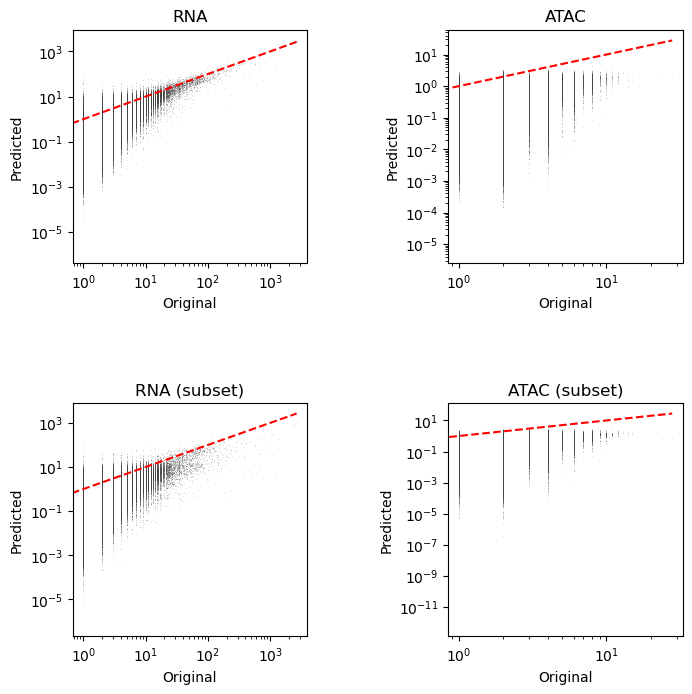

In [8]:
# make a figure with 4 subplots (2x2)

fig = plt.figure(figsize=(20 * cm, 20 * cm))
gs = gridspec.GridSpec(2, 2, figure=fig)
gs.update(wspace=0.6, hspace=0.6)
ax_list = []

# top row will be full model
ax_list.append(fig.add_subplot(gs[0, 0]))
sns.scatterplot(
    x=raw_data[0].flatten(),
    y=predictions_full[0].flatten(),
    ax=ax_list[-1],
    s=0.1,
    color="black",
)
# plot a red line for the originals
ax_list[-1].plot(
    [raw_data[0].flatten().min(), raw_data[0].flatten().max()],
    [raw_data[0].flatten().min(), raw_data[0].flatten().max()],
    #transform=ax_list[-1].transAxes,
    color="red",
    linestyle="--",
)
ax_list[-1].set_xlabel("Original")
ax_list[-1].set_ylabel("Predicted")
ax_list[-1].set_yscale("log")
ax_list[-1].set_xscale("log")
ax_list[-1].set_title("RNA")

ax_list.append(fig.add_subplot(gs[0, 1]))
sns.scatterplot(
    x=raw_data[1].flatten(),
    y=predictions_full[1].flatten(),
    ax=ax_list[-1],
    s=0.1,
    color="black",
)
# plot a red line for the originals
ax_list[-1].plot(
    [raw_data[1].flatten().min(), raw_data[1].flatten().max()],
    [raw_data[1].flatten().min(), raw_data[1].flatten().max()],
    #transform=ax_list[-1].transAxes,
    color="red",
    linestyle="--",
)
ax_list[-1].set_xlabel("Original")
ax_list[-1].set_ylabel("Predicted")
ax_list[-1].set_yscale("log")
ax_list[-1].set_xscale("log")
ax_list[-1].set_title("ATAC")

# bottom row will be small model
ax_list.append(fig.add_subplot(gs[1, 0]))
sns.scatterplot(
    x=raw_data[0].flatten(),
    y=predictions_small[0].flatten(),
    ax=ax_list[-1],
    s=0.1,
    color="black",
)
# plot a red line for the originals
ax_list[-1].plot(
    [raw_data[0].flatten().min(), raw_data[0].flatten().max()],
    [raw_data[0].flatten().min(), raw_data[0].flatten().max()],
    #transform=ax_list[-1].transAxes,
    color="red",
    linestyle="--",
)
ax_list[-1].set_xlabel("Original")
ax_list[-1].set_ylabel("Predicted")
ax_list[-1].set_yscale("log")
ax_list[-1].set_xscale("log")
ax_list[-1].set_title("RNA (subset)")

ax_list.append(fig.add_subplot(gs[1, 1]))
sns.scatterplot(
    x=raw_data[1].flatten(),
    y=predictions_small[1].flatten(),
    ax=ax_list[-1],
    s=0.1,
    color="black",
)
# plot a red line for the originals
ax_list[-1].plot(
    [raw_data[1].flatten().min(), raw_data[1].flatten().max()],
    [raw_data[1].flatten().min(), raw_data[1].flatten().max()],
    #transform=ax_list[-1].transAxes,
    color="red",
    linestyle="--",
)
ax_list[-1].set_xlabel("Original")
ax_list[-1].set_ylabel("Predicted")
ax_list[-1].set_yscale("log")
ax_list[-1].set_xscale("log")
ax_list[-1].set_title("ATAC (subset)")

plt.savefig(plot_dir + "bonemarrow_test_predictions_scatter_subset.png", dpi=300, bbox_inches='tight')

In [2]:
# load data
data_name = "human_bonemarrow"
raw_data = [
    np.load(result_dir + "performance/" + data_name + "_test_original_RNA.npy"),
    np.load(result_dir + "performance/" + data_name + "_test_original_ATAC.npy"),
]
model_name = "l20_e2_d2"
predictions_full = [
    np.load(result_dir + "performance/" + model_name + "_test_predictions_RNA.npy"),
    np.load(result_dir + "performance/" + model_name + "_test_predictions_ATAC.npy"),
]
model_name = "l20_e2_d2_rs0_subset567"
predictions_small = [
    np.load(result_dir + "performance/" + model_name + "_test_predictions_RNA.npy"),
    np.load(result_dir + "performance/" + model_name + "_test_predictions_ATAC.npy"),
]

In [3]:
import torch

def binarize(x, threshold=0.5):
    x[x >= threshold] = 1
    x[x < threshold] = 0
    return x

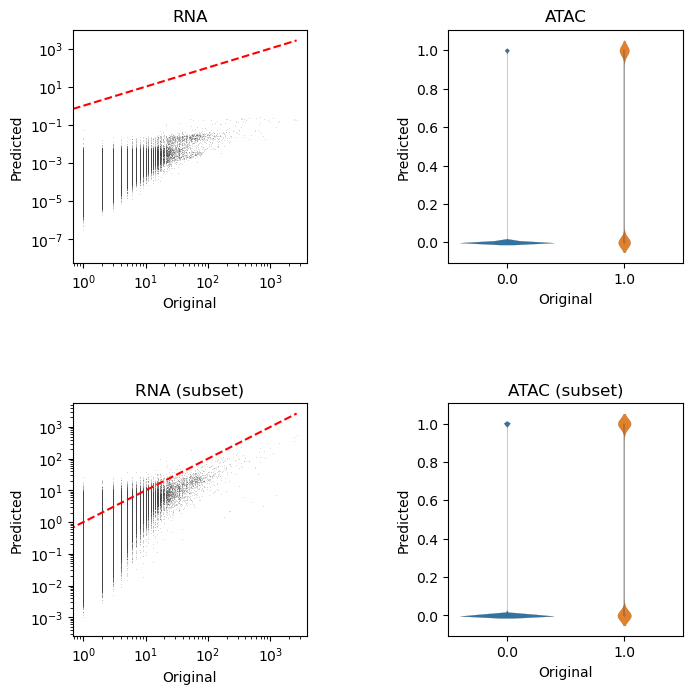

In [4]:
# make a figure with 4 subplots (2x2)

fig = plt.figure(figsize=(20 * cm, 20 * cm))
gs = gridspec.GridSpec(2, 2, figure=fig)
gs.update(wspace=0.6, hspace=0.6)
ax_list = []

# top row will be full model
ax_list.append(fig.add_subplot(gs[0, 0]))
sns.scatterplot(
    x=raw_data[0].flatten(),
    y=predictions_full[0].flatten(),
    ax=ax_list[-1],
    s=0.1,
    color="black",
)
# plot a red line for the originals
ax_list[-1].plot(
    [raw_data[0].flatten().min(), raw_data[0].flatten().max()],
    [raw_data[0].flatten().min(), raw_data[0].flatten().max()],
    #transform=ax_list[-1].transAxes,
    color="red",
    linestyle="--",
)
ax_list[-1].set_xlabel("Original")
ax_list[-1].set_ylabel("Predicted")
ax_list[-1].set_yscale("log")
ax_list[-1].set_xscale("log")
ax_list[-1].set_title("RNA")

ax_list.append(fig.add_subplot(gs[0, 1]))
sns.violinplot(
    x=binarize(torch.tensor(raw_data[1].flatten())).numpy(),
    y=binarize(torch.tensor(predictions_full[1].flatten())).numpy(),
    ax=ax_list[-1],
    linewidth=0.1,
)
ax_list[-1].set_xlabel("Original")
ax_list[-1].set_ylabel("Predicted")
#ax_list[-1].set_yscale("log")
#ax_list[-1].set_xscale("log")
ax_list[-1].set_title("ATAC")

# bottom row will be small model
ax_list.append(fig.add_subplot(gs[1, 0]))
sns.scatterplot(
    x=raw_data[0].flatten(),
    y=predictions_small[0].flatten(),
    ax=ax_list[-1],
    s=0.1,
    color="black",
)
# plot a red line for the originals
ax_list[-1].plot(
    [raw_data[0].flatten().min(), raw_data[0].flatten().max()],
    [raw_data[0].flatten().min(), raw_data[0].flatten().max()],
    #transform=ax_list[-1].transAxes,
    color="red",
    linestyle="--",
)
ax_list[-1].set_xlabel("Original")
ax_list[-1].set_ylabel("Predicted")
ax_list[-1].set_yscale("log")
ax_list[-1].set_xscale("log")
ax_list[-1].set_title("RNA (subset)")

ax_list.append(fig.add_subplot(gs[1, 1]))
# make this a violin plot
sns.violinplot(
    x=binarize(torch.tensor(raw_data[1].flatten())).numpy(),
    y=binarize(torch.tensor(predictions_small[1].flatten())).numpy(),
    ax=ax_list[-1],
    linewidth=0.1,
)
ax_list[-1].set_xlabel("Original")
ax_list[-1].set_ylabel("Predicted")
#ax_list[-1].set_yscale("log")
#ax_list[-1].set_xscale("log")
ax_list[-1].set_title("ATAC (subset)")

plt.savefig(plot_dir + "bonemarrow_test_predictions_scatter_subset_mvi.png", dpi=300, bbox_inches='tight')

In [5]:
import torch

def binarize(x, threshold=0.5):
    x[x >= threshold] = 1
    x[x < threshold] = 0
    return x

x_accessibility = binarize(torch.tensor(raw_data[1].flatten()))
y_accessibility = binarize(torch.tensor(predictions_small[1].flatten()))

p = (x_accessibility == 1)
pp = (y_accessibility == 1)
tp = torch.logical_and(p,pp).sum(0).float()
tn = torch.logical_and(~p,~pp).sum(0).float()
fp = (y_accessibility > x_accessibility).sum(0).float()
fn = (y_accessibility < x_accessibility).sum(0).float()

tpr = tp / (tp + fn) # sensitivity
tnr = tn / (tn + fp) # specificity
balanced_accuracy = (tpr + tnr) / 2
print(balanced_accuracy.item())

0.7120348215103149


In [6]:
import torch

def binarize(x, threshold=0.5):
    x[x >= threshold] = 1
    x[x < threshold] = 0
    return x

x_accessibility = binarize(torch.tensor(raw_data[1].flatten()))
y_accessibility = binarize(torch.tensor(predictions_full[1].flatten()))

p = (x_accessibility == 1)
pp = (y_accessibility == 1)
tp = torch.logical_and(p,pp).sum(0).float()
tn = torch.logical_and(~p,~pp).sum(0).float()
fp = (y_accessibility > x_accessibility).sum(0).float()
fn = (y_accessibility < x_accessibility).sum(0).float()

tpr = tp / (tp + fn) # sensitivity
tnr = tn / (tn + fp) # specificity
balanced_accuracy = (tpr + tnr) / 2
print(balanced_accuracy.item())

0.6966515183448792
